Melissa Graham, Fri Oct 25 <br>
In this notebook we test two linear interpolation packages with our photo-z results data.

In [1]:
### Import needed packages
import os
import numpy as np
from copy import deepcopy
# import pandas as pd
# import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import griddata
from sklearn import linear_model

In [2]:
### Read the photo-z results into numpy arrays (like we did with example_read_grid_data.ipynb).
### Limiting magnitudes in ugrizy from the first six columns
maglims = np.loadtxt( 'grid_stddevs.dat', dtype='float', usecols=(0,1,2,3,4,5))
### Standard deviation in lowest redshift bin from the 7th column
values = np.loadtxt( 'grid_stddevs.dat', dtype='float', usecols={6})

### Define a set of limiting magnitudes to use for this example
test_maglims = np.asarray( [26.0, 26.0, 26.0, 26.0, 26.0, 24.0], dtype='float' )

In [3]:
### Let's try using the scipy.interpolate package's griddata function
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

### method='nearest'
### "returns the value at the data point closest to the point of interpolation"
### (This is not really 'interpolating'.)
results = griddata(maglims,values,test_maglims,method='nearest')
print('method = nearest')
print(results)
del results

### method='linear'
### "tessellate the input point set to n-dimensional simplices, and interpolate linearly on each simplex"
results = griddata(maglims,values,test_maglims,method='linear')
print('method = linear')
print(results)
del results

method = nearest
[ 0.0356]
method = linear
[ nan]


Based on the above, we can see that scipy.interpolate.griddata with method='linear' fails for our data set. <br>
This is probably because our data is too sparsely sampled. <br> 
Instead, let's try sklearn's linear_model for this work.<br><br><br>

In [20]:
### Apply sklearn's linear_model LinearRegression
### https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
reg = linear_model.LinearRegression()
reg.fit(maglims,values)
print("Coefficients: ", reg.coef_)
print("Intercept: ", reg.intercept_)
print('reg.predict(test_maglims) = ', reg.predict(test_maglims.reshape(1,-1)) )
del reg

Coefficients:  [-0.00130775 -0.00273077 -0.00527715 -0.00203297  0.00183958  0.00081755]
Intercept:  0.265489972514
reg.predict(test_maglims) =  [ 0.03787556]


Based on the above, it looks like sklearn.linear_model.LinearRegression will work.<br>
<br><br><br>
But how much better does sklearn do than the scipy option to simply taking the nearest grid point? <br>

In [21]:
### Loop over our data, remove each point, and then do the interpolation at that point
### Calculate the interpolated value from both the sklearn and scipy interpolators
### Also calculate the 6D distance to the nearest point, and to the baseline (row 0)

sk_results  = np.zeros( len(maglims), dtype='float' )
sk_diff     = np.zeros( len(maglims), dtype='float' )

sp_results  = np.zeros( len(maglims), dtype='float' )
sp_diff     = np.zeros( len(maglims), dtype='float' )

dm_nearest  = np.zeros( len(maglims), dtype='float' )
dm_baseline = np.zeros( len(maglims), dtype='float' )

for i in range(len(maglims)):

    ### Make deep copies of the points and values
    temp1 = deepcopy(maglims)
    temp2 = deepcopy(values)

    ### Remove the ith row of each of these arrays and delete temps
    temp_maglims = np.delete(temp1,i,axis=0)
    temp_values  = np.delete(temp2,i,axis=0)
    del temp1,temp2

    ### For this point, calculate the 6D distance to:
    ###  dm_nearest  = the nearest grid point 
    ###  dm_baseline = the point that represents a baseline survey (row=0)
    test_maglim = deepcopy(maglims[i])
    dm_nearest[i] = np.min( np.sqrt( np.sum( (temp_maglims-test_maglim)**2, axis=1 ) ) )
    dm_baseline[i] = np.sqrt( np.sum( (maglims[0]-test_maglim)**2 ) )

    ### Interpolate using sklearn's linear_model
    reg = linear_model.LinearRegression()
    reg.fit(temp_maglims,temp_values)
    tmp = test_maglim.reshape(1,-1) ### If we don't reshape, deprecation error
    sk_results[i] = reg.predict(tmp.reshape(1,-1))
    sk_diff[i]    = np.abs(values[i] - sk_results[i])
    del reg,tmp

    ### Interpolate using scipy's interpolate.griddata with method=nearest
    sp_results[i] = griddata(temp_maglims,temp_values,test_maglim,method='nearest')
    sp_diff[i]    = np.abs(values[i] - sp_diff[i])

    ### Clean up
    del temp_maglims,temp_values,test_maglim

print('This cell runs silent. Done.')

This cell runs silent. Done.


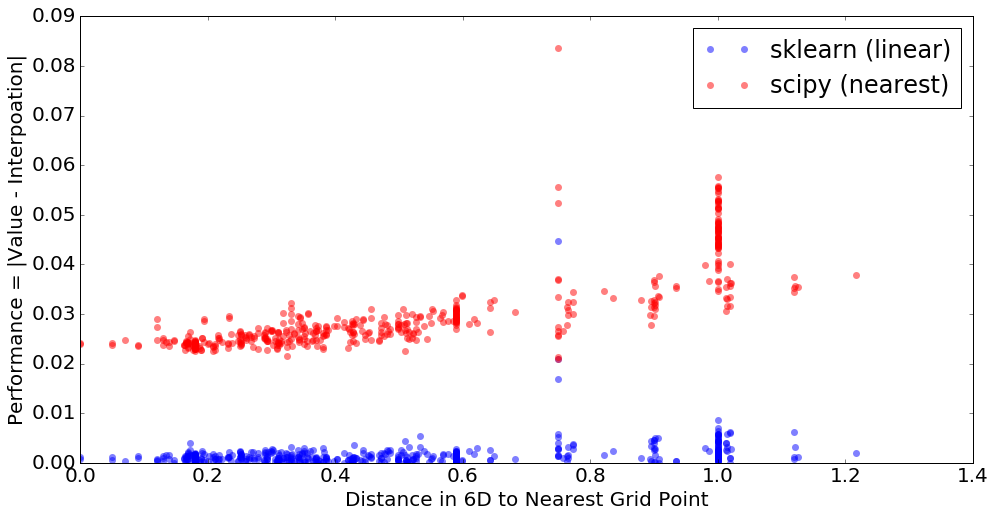

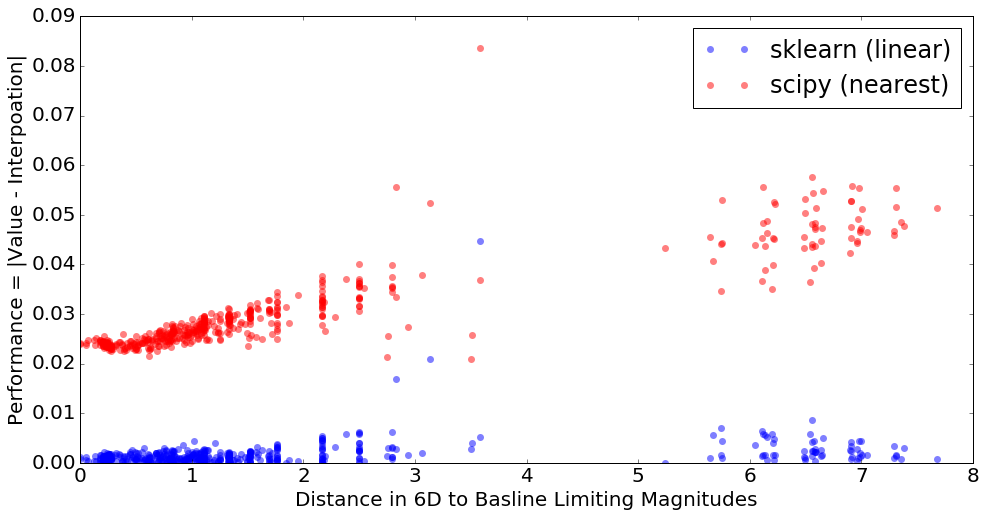

In [22]:
### Plot the performance of each of these interpolations as a function of:
###  (1) The 6D distance to the nearest grid point
###  (2) The 6D distance to the baseline set of limiting magnitudes

plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size':20})
plt.axhline(0.0,color='grey')
plt.plot(dm_nearest, sk_diff, 'o', ms=7, alpha=0.5, mew=0, color='blue', label='sklearn (linear)')
plt.plot(dm_nearest, sp_diff, 'o', ms=7, alpha=0.5, mew=0, color='red', label='scipy (nearest)')
plt.xlabel('Distance in 6D to Nearest Grid Point')
plt.ylabel('Performance = |Value - Interpoation|')
plt.legend(loc='upper right')
# plt.xlim([-0.1,1.4])
# plt.ylim([-0.01,0.10])
plt.show()

plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size':20})
plt.axhline(0.0,color='grey')
plt.plot(dm_baseline, sk_diff, 'o', ms=7, alpha=0.5, mew=0, color='blue', label='sklearn (linear)')
plt.plot(dm_baseline, sp_diff, 'o', ms=7, alpha=0.5, mew=0, color='red', label='scipy (nearest)')
plt.xlabel('Distance in 6D to Basline Limiting Magnitudes')
plt.ylabel('Performance = |Value - Interpoation|')
plt.legend(loc='upper right')
# plt.xlim([-0.1,4.0])
# plt.ylim([-0.01,0.10])
plt.show()